In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf

In [48]:
SPY = pd.read_pickle('SPY_with_events.pkl')



In [49]:
SPY.info()
SPY_= SPY['SPY_Close']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321 entries, 0 to 1320
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          1321 non-null   datetime64[ns]
 1   SPY_Close   1321 non-null   float64       
 2   SPY_Volume  1321 non-null   int64         
 3   month       1321 non-null   int32         
 4   day         1321 non-null   int32         
 5   event       1321 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1), object(1)
memory usage: 51.7+ KB


In [34]:
result = seasonal_decompose(SPY['SPY_Close'], model= 'multiplicative',period=250) # 250 trading days in a year

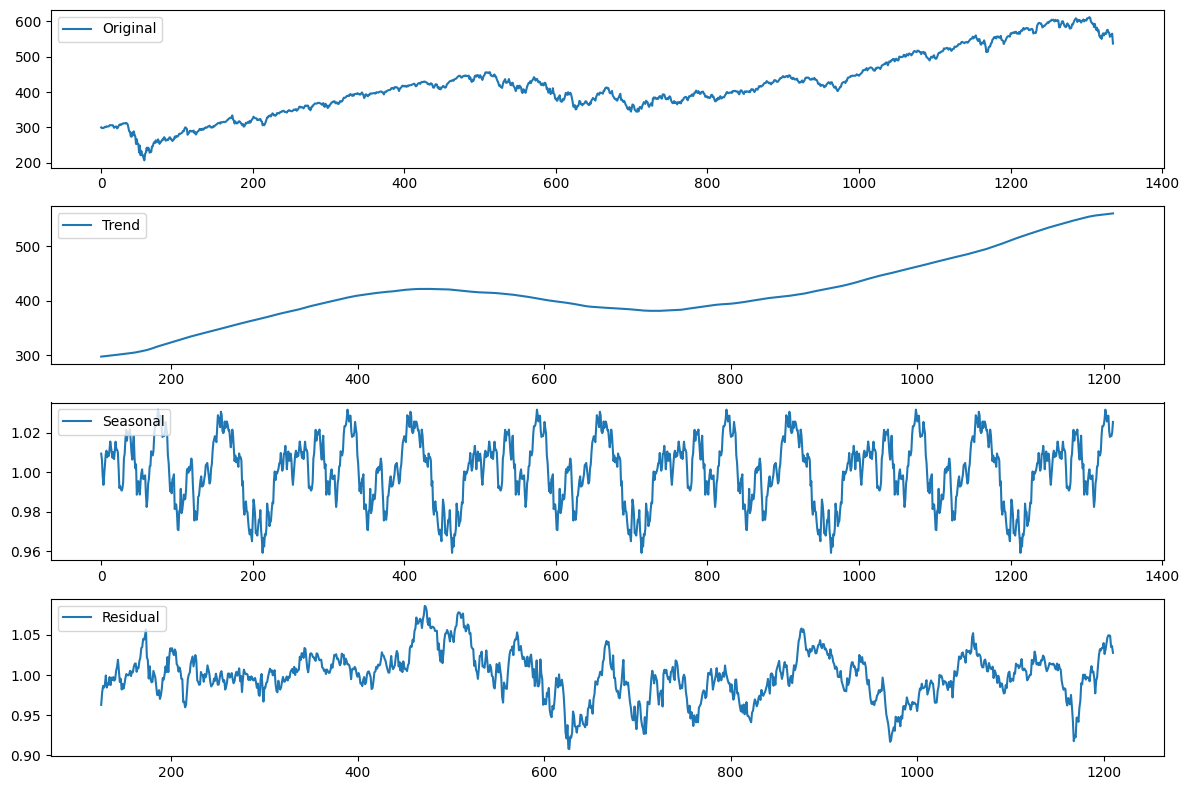

In [35]:
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(SPY['SPY_Close'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [14]:
print(SPY.iloc[180:210])

            ds   SPY_Close  SPY_Volume                   event
180 2020-09-18  310.020386   105877900              none event
181 2020-09-21  306.569977    99450800              none event
182 2020-09-22  309.692230    63612100              none event
183 2020-09-23  302.510162    93112200              none event
184 2020-09-24  303.316528    76681300              none event
185 2020-09-25  308.220215    71069400              none event
186 2020-09-28  313.339600    64584600              none event
187 2020-09-29  311.633118    51304000              none event
188 2020-09-30  313.995911   104081100              none event
189 2020-10-01  316.011780    88698700                     ISM
190 2020-10-02  313.011444    89431100         nonfarm payroll
191 2020-10-05  318.562012    45713100              none event
192 2020-10-06  314.033356    90128900              none event
193 2020-10-07  319.499664    56999600              none event
194 2020-10-08  322.331177    45242500              non

In [36]:
seasonal_values = pd.DataFrame(result.seasonal)
seasonal_values.head()
SPY_copy = SPY.copy()
SPY_copy = pd.concat([SPY_copy, seasonal_values], axis=1)

SPY_copy['season_rank'] = SPY_copy['seasonal'].apply(lambda x: 1 if x > 1.01 else -1 if x <0.99 else 0)
SPY_copy.head()
#print(result.seasonal[180:210])

,ds,SPY_Close,SPY_Volume,event,seasonal,season_rank
0,2020-01-02,300.291656,59151200,none event,1.009396,0
1,2020-01-03,298.017670,77709700,"ISM Manufacturing ,PMI",1.006236,0
2,2020-01-06,299.154602,55653900,none event,0.997950,0
3,2020-01-07,298.313507,40496400,none event,0.993598,0
4,2020-01-08,299.903412,68296000,none event,0.998804,0


In [6]:
print(SPY_copy.loc[SPY_copy['season_rank'] == -1, ])

             ds   SPY_Close  SPY_Volume                   event  seasonal  \
40   2020-03-02  285.705414   238703600                     ISM  0.985421   
44   2020-03-06  274.955261   228667200         nonfarm payroll  0.989109   
52   2020-03-18  221.842545   327597100  interest rate decision  0.987215   
53   2020-03-19  222.313889   289322000              none event  0.985202   
90   2020-05-12  266.539795    95870800              none event  0.987198   
...         ...         ...         ...                     ...       ...   
1220 2024-11-06  587.290710    68182000              none event  0.984569   
1290 2025-02-20  608.549377    36554000              none event  0.985421   
1294 2025-02-26  592.756836    43321600              none event  0.989109   
1302 2025-03-10  558.898743    99326600              none event  0.987215   
1303 2025-03-11  554.252686    88102100              none event  0.985202   

      season_rank  
40             -1  
44             -1  
52             

In [22]:
SPY_copy.to_pickle('SPY_with_seasonal.pkl')

A statistical test used to check whether a time series is stationary — which is a core requirement for ARIMA models:

In [7]:
result_adf = adfuller(SPY['SPY_Close'])
print(f'ADF Statistics: {result_adf[0]}')
print(f'p-value: {result_adf[1]}')
print(f'critical values : ')
for key, value in result_adf[4].items():
    print(f'   {key} : {value}')


ADF Statistics: -0.6710680303287874
p-value: 0.8541019327698391
critical values : 
   1% : -3.4353669981294908
   5% : -2.8637555937483143
   10% : -2.5679495948256252


# Arima

0    300.291656
1    298.017670
2    299.154602
3    298.313507
4    299.903412
5    301.936890
6    301.067993
7    303.138519
8    302.676453
9    302.676453
Name: SPY_Close, dtype: float64
ACF values: 
[ 1.00000000e+00 -8.74443086e-02  7.72428802e-02 -7.65688348e-02
  2.97283174e-02 -3.80408174e-02  1.90127210e-03  2.28682794e-02
 -1.46047589e-02  4.19501071e-02 -2.11712758e-02  2.55586842e-02
 -3.81809381e-02  1.21602607e-02 -1.01926760e-02 -4.16271841e-02
 -9.19504571e-03 -2.66085139e-02  7.85040529e-02 -1.79055564e-02
  4.64438361e-02  2.56895044e-04 -3.10516376e-02 -2.02018008e-02
 -1.19323647e-02 -1.48628066e-02 -5.62750793e-02  3.47240902e-02
 -9.25695765e-04  2.44964298e-02 -2.12454267e-02 -8.83339550e-03
 -2.48050803e-02 -4.25889675e-03 -6.64086954e-03  3.59735978e-02
 -1.18241941e-03 -1.67007644e-02  4.27693204e-03 -1.05823305e-02
 -1.02261511e-03 -3.09046337e-02  2.68244531e-02 -6.30930680e-03
 -2.61751481e-02  3.01534724e-04  4.72620740e-02 -2.97587437e-02
  1.64773433e-0

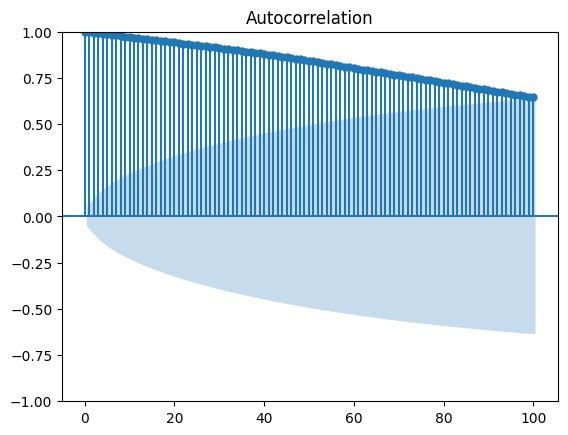

In [39]:
SPY_return = SPY['SPY_Close']
print(SPY_return.head(10))
acf_value = acf(SPY_return.diff(1).dropna(),nlags=100)
# print acf values:
print('ACF values: ')
print(acf_value)
#creat acf plot:
plot_acf(SPY_return, lags=100)
plt.show()

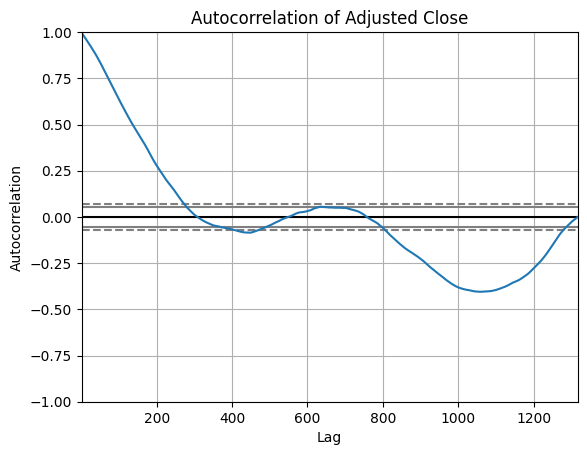

In [34]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(SPY['SPY_Close'].tolist())
plt.title("Autocorrelation of Adjusted Close")
plt.grid(True)
plt.show()

In [ ]:
#from pmdarima.arima.utils import ndiffs

In [10]:
from statsmodels.tsa.stattools import adfuller

def estimate_d(series, max_d=6, significance=0.05):
    """Estimate the order of differencing needed using ADF test."""
    d = 0
    p_value = adfuller(series.dropna())[1]
    
    while p_value > significance and d < max_d:
        d += 1
        series = series.diff().dropna()
        p_value = adfuller(series)[1]
    
    return d

# Example usage:
d = estimate_d(SPY['SPY_Close'])
print(f'd = {d}')


d = 1


PACF Values (after differencing)
[ 1.          0.99795532 -0.02652036 -0.0434423   0.05515103 -0.0098656
 -0.00724158 -0.00712944 -0.03323083  0.01191246 -0.00269837  0.01009183
 -0.01740379  0.04390592 -0.03007783  0.01332009  0.06681147 -0.03471948
  0.00847264 -0.05438934 -0.04040178 -0.01321815 -0.05550486  0.04354196
  0.00556629 -0.02109984  0.0472705   0.00448728 -0.0194572  -0.00999708
 -0.02016909 -0.02179679]


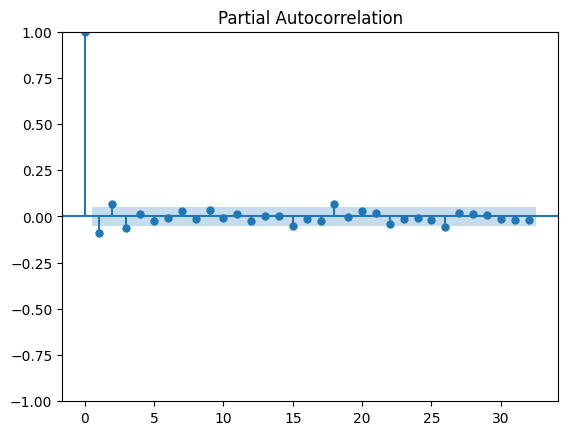

In [42]:
# חישוב ה-PACF על הנתונים המדיפרנציאלים
pacf_values = pacf(SPY['SPY_Close'])

# הדפסת ערכי PACF
print("PACF Values (after differencing)")
print(pacf_values)

# יצירת גרף PACF
plot_pacf(SPY['SPY_Close'].diff().dropna())
plt.show()
# 7 

# Classic arima 

In [51]:
split = int(len(SPY)*0.9)
train = SPY.iloc[:split]
test = SPY.iloc[split:]


In [43]:
model = ARIMA(train['SPY_Close'], order=(3,1,100))
model_fit = model.fit()



c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
forecast = model_fit.get_forecast(steps=len(test))
predictions = forecast.predicted_mean
conf_int = forecast.conf_int()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              SPY_Close   No. Observations:                 1202
Model:               ARIMA(3, 1, 100)   Log Likelihood               -3467.247
Date:                Mon, 07 Apr 2025   AIC                           7142.493
Time:                        14:24:57   BIC                           7671.948
Sample:                             0   HQIC                          7341.927
                               - 1202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0404      6.199     -0.007      0.995     -12.191      12.110
ar.L2          0.1046      3.576      0.029      0.977      -6.904       7.113
ar.L3          0.1050      1.007      0.104      0.9

In [45]:
# Evaluate the model:
mse = mean_squared_error(test['SPY_Close'], predictions)
mae = mean_absolute_error(test['SPY_Close'], predictions)
print(f'mse: {mse} mae: {mae}')

mse: 468.3268638499966 mae: 18.339115845877796


# SARIMAX

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

In [54]:
n_test = len(test)
# Parameter range 
p = q = range(1,8)
d= range(1,4)
P = D = Q = range(0,2)
m=5
# Collect results
results = []

  4%|▍         | 6/147 [00:15<06:18,  2.69s/it]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 10/147 [00:30<08:24,  3.68s/it]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check ml


Best SARIMA Order: (1, 3, 7) x (0, 1, 0, 5)
Best MSE: 194.14
Best R2: 0.2039


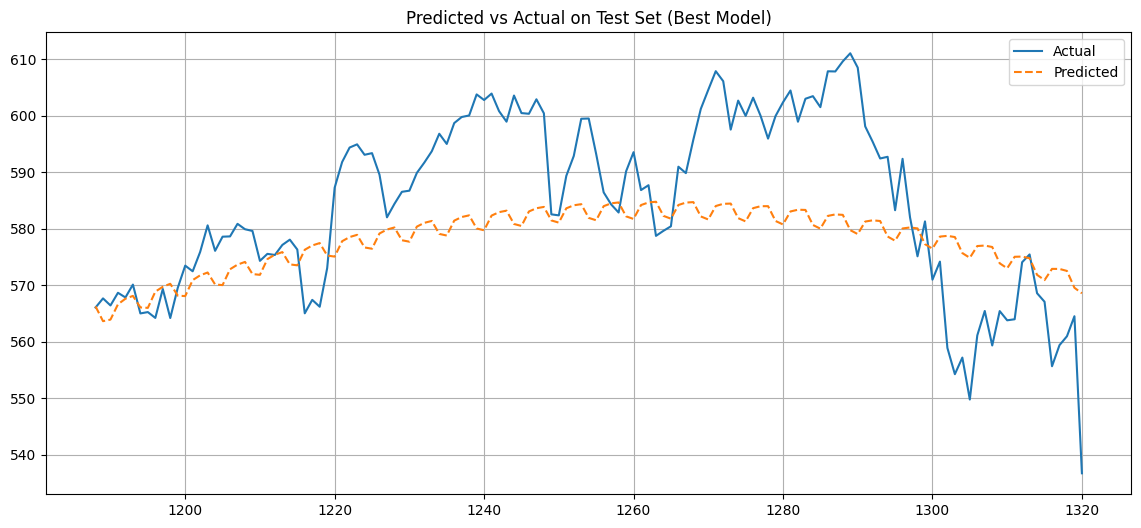

In [55]:
# Grid search
for param in tqdm([(i,j,k) for i in p for j in d for k in q]):
    for seasonal in [(i,j,k) for i in P for j in D for k in Q]:
        order = param
        seasonal_order = seasonal + (m,)
        try:
            model = SARIMAX(train['SPY_Close'],
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False)

            forecast = model_fit.forecast(steps=n_test)
            mse = mean_squared_error(test['SPY_Close'], forecast)
            r2 = r2_score(test['SPY_Close'], forecast)

            results.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'mse': mse,
                'r2': r2,
                'forecast': forecast
            })
        except:
            continue

# Sort results by lowest MSE
results_sorted = sorted(results, key=lambda x: x['mse'])
best_result = results_sorted[0]

print(f"\nBest SARIMA Order: {best_result['order']} x {best_result['seasonal_order']}")
print(f"Best MSE: {best_result['mse']:.2f}")
print(f"Best R2: {best_result['r2']:.4f}")

# Assign predictions to test
test['PREDICTED'] = best_result['forecast'].values

# Plot predicted vs actual
plt.figure(figsize=(14,6))
plt.plot(test['SPY_Close'], label='Actual')
plt.plot(test['PREDICTED'], label='Predicted', linestyle='--')
plt.title('Predicted vs Actual on Test Set (Best Model)')
plt.legend()
plt.grid()
plt.show()



In [56]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          SPY_Close   No. Observations:                 1188
Model:             SARIMAX(7, 3, 7)x(0, 1, [], 5)   Log Likelihood               -3552.640
Date:                            Tue, 08 Apr 2025   AIC                           7135.280
Time:                                    17:09:29   BIC                           7211.277
Sample:                                         0   HQIC                          7163.941
                                           - 1188                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3739      0.651     -2.110      0.035      -2.650      -0.098
ar.L2         -1.1967      0.644   

mse: 194.1433335838432 r2: 0.20390067286554225


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\OMER\AppData\Local\Temp\ipykernel_51128\4003431356.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PREDICTED'] = forecast_1_df['forecast']#.values


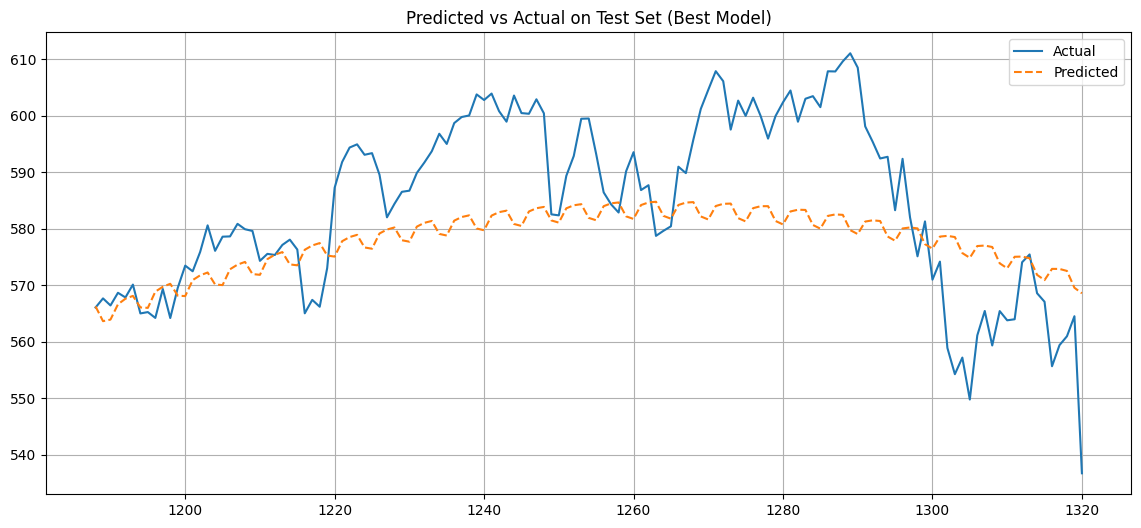

In [61]:
model_1 = SARIMAX(train['SPY_Close'],
                      order=best_result['order'],seasonal_order=best_result['seasonal_order'],
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit(disp=False)

forecast_1 = model_1.forecast(steps = len(test))
#future_1_index = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=len(test), freq='D')
forecast_1_df = pd.DataFrame({'forecast': forecast_1}, index = test.index)

mse = mean_squared_error(test['SPY_Close'], forecast_1)
r2 = r2_score(test['SPY_Close'], forecast_1)
print(f'mse: {mse} r2: {r2}')
# Assign predictions to test
test['PREDICTED'] = forecast_1_df['forecast']#.values

# Plot predicted vs actual
plt.figure(figsize=(14,6))
plt.plot(test['SPY_Close'], label='Actual')
plt.plot(test['PREDICTED'], label='Predicted', linestyle='--')
plt.title('Predicted vs Actual on Test Set (Best Model)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Forecast next 21 days
final_model = SARIMAX(df['^GSPC'],
                      order=best_result['order'],
                      seasonal_order=best_result['seasonal_order'],
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit(disp=False)

future_forecast = final_model.forecast(steps=21)
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=21, freq='D')
forecast_df = pd.DataFrame({'FORECAST': future_forecast}, index=future_index)

# Plot forecast
plt.figure(figsize=(14,6))
plt.plot(df['^GSPC'], label='Historical')
plt.plot(forecast_df['FORECAST'], label='21-Day Forecast', color='red')
plt.title('21-Day Forecast')
plt.legend()
plt.grid()
plt.show()

# Print all tested parameter combinations and results
results_df = pd.DataFrame([
    {
        'order': r['order'],
        'seasonal_order': r['seasonal_order'],
        'mse': r['mse'],
        'r2': r['r2']
    } for r in results_sorted
])
print("\nTop 10 Models:")
print(results_df.head(10))

In [83]:
SPY.head()

,ds,SPY_Close,SPY_Volume,month,day,event
0,2020-01-02,300.291656,59151200,1,2,none event
1,2020-01-03,298.017670,77709700,1,3,"ISM Manufacturing ,PMI"
2,2020-01-06,299.154602,55653900,1,6,none event
3,2020-01-07,298.313507,40496400,1,7,none event
4,2020-01-08,299.903412,68296000,1,8,none event


# Return model :  sarima

In [91]:
SPY_return = SPY['SPY_Close'].pct_change()* 100

In [92]:
#SPY_return.columns = ['SPY_Return']  
#SPY_return = SPY_return.reset_index(drop=True)
SPY_return = SPY_return.dropna()   

In [93]:
SPY_return.head()

1   -0.757259
2    0.381498
3   -0.281157
4    0.532964
5    0.678044
Name: SPY_Close, dtype: float64

In [94]:
split_return = int(len(SPY_return)*0.9)
train_return = SPY_return.iloc[:split]
test_return = SPY_return.iloc[split:]


In [82]:
train_return.head()

1   -0.757259
2    0.381498
3   -0.281157
4    0.532964
5    0.678044
Name: SPY_Close, dtype: float64

In [95]:
n_test = len(test)
# Parameter range 
p = q = range(1,8)
d= range(0,2)
P = D = Q = range(0,2)
m=5
# Collect results
results = []

In [ ]:
# Grid search
for param in tqdm([(i,j,k) for i in p for j in d for k in q]):
    for seasonal in [(i,j,k) for i in P for j in D for k in Q]:
        order = param
        seasonal_order = seasonal + (m,)
        try:
            model = SARIMAX(train_return,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False)

            forecast = model_fit.forecast(steps=n_test)
            mse = mean_squared_error(test_return, forecast)
            r2 = r2_score(test_return, forecast)

            results.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'mse': mse,
                'r2': r2,
                'forecast': forecast
            })
        except Exception as e:
    print(f"Failed for order={order}, seasonal={seasonal_order} → {e}")
    #continue
        # Handle convergence issues or other exceptions
        if 'ConvergenceWarning' in str(e) or 'ValueError' in str(e):
            print(f"Model failed to converge for order={order}, seasonal={seasonal_order}")
            continue
        if 'LinAlgError' in str(e):
            print(f"Linear algebra error for order={order}, seasonal={seasonal_order}")
            continue
        if 'NotImplementedError' in str(e):
            print(f"Not implemented error for order={order}, seasonal={seasonal_order}")
            continue
        if 'RuntimeError' in str(e):
            print(f"Runtime error for order={order}, seasonal={seasonal_order}")
            continue

# Sort results by lowest MSE
results_sorted = sorted(results, key=lambda x: x['mse'])
if not results_sorted:
    raise ValueError("No SARIMA models converged. Check data, ranges, or try differencing again.")

best_result = results_sorted[0]

print(f"\nBest SARIMA Order: {best_result['order']} x {best_result['seasonal_order']}")
print(f"Best MSE: {best_result['mse']:.2f}")
print(f"Best R2: {best_result['r2']:.4f}")

# Assign predictions to test
test_return['PREDICTED'] = best_result['forecast'].values

# Plot predicted vs actual
plt.figure(figsize=(14,6))
plt.plot(test_return, label='Actual')
plt.plot(test_return['PREDICTED'], label='Predicted', linestyle='--')
plt.title('Predicted vs Actual on Test Set (Best Model)')
plt.legend()
plt.grid()
plt.show()



  0%|          | 0/98 [00:00<?, ?it/s]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837:

IndexError: list index out of range

In [97]:
combined = pd.read_pickle('combined_cleaned_add.pkl')
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1321 entries, 0 to 1320
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SPY_Close            1321 non-null   float64       
 1   SPY_Volume           1321 non-null   float64       
 2   AAPL                 1321 non-null   float64       
 3   MSFT                 1321 non-null   float64       
 4   GOOG                 1321 non-null   float64       
 5   GLD                  1321 non-null   float64       
 6   SLV                  1321 non-null   float64       
 7   ^TNX                 1321 non-null   float64       
 8   DX-Y.NYB             1321 non-null   float64       
 9   JPY=X                1321 non-null   float64       
 10  EUR=X                1321 non-null   float64       
 11  USO                  1321 non-null   float64       
 12  UNG                  1321 non-null   float64       
 13  BTC-USD              1321 non-null   f

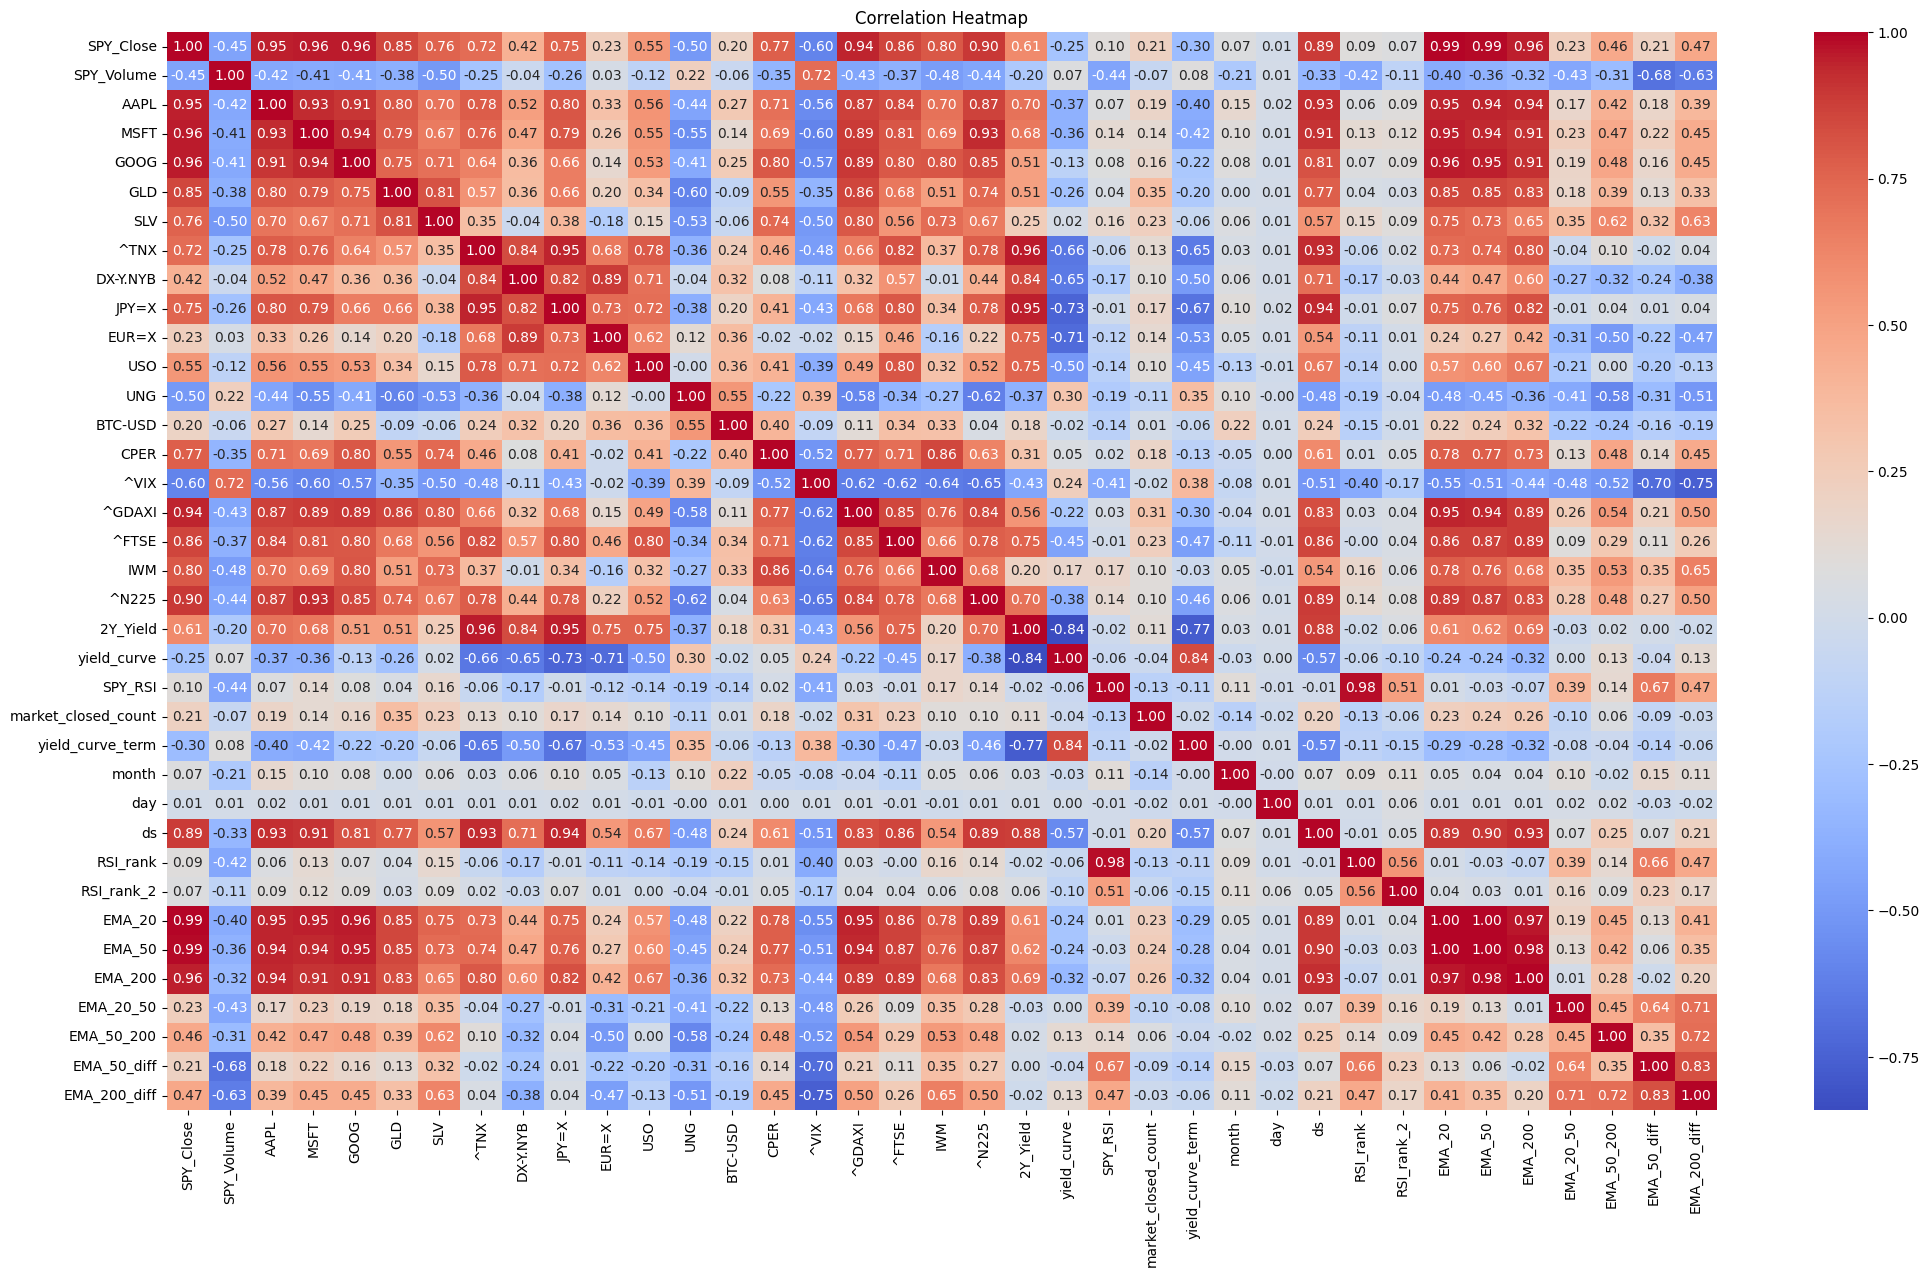

In [99]:
import seaborn as sns
plt.figure(figsize=(25,14))
sns.heatmap(combined.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [117]:
combined = combined.dropna()

In [130]:
x = combined.drop(columns=['SPY_Close'])
y = combined['SPY_Close']



In [131]:
# Step 1: Calculate correlation of each feature with y
correlations = x.corrwith(y)

# Step 2: Filter features based on the condition
mask = (correlations > 0.6) | (correlations < -0.15)
filtered_x = x.loc[:, mask]

# Optional: See what was kept
selected_corr_features = correlations[mask]
print("Selected features based on correlation threshold:")
print(selected_corr_features.sort_values())


Selected features based on correlation threshold:
^VIX               -0.621592
UNG                -0.494249
SPY_Volume         -0.462521
yield_curve_term   -0.293529
yield_curve        -0.249781
2Y_Yield            0.609308
^TNX                0.719842
JPY=X               0.745890
SLV                 0.757710
CPER                0.767941
IWM                 0.794263
GLD                 0.847079
^FTSE               0.872139
ds                  0.888593
^N225               0.894859
^GDAXI              0.944950
AAPL                0.950697
EMA_200             0.954825
MSFT                0.958207
GOOG                0.959009
EMA_50              0.987124
EMA_20              0.994488
dtype: float64


In [120]:
filtered_x['day_of_week'] = filtered_x['ds'].dt.dayofweek        # Monday = 0, Sunday = 6
filtered_x['month'] = filtered_x.ds.dt.month                  # 1–12
filtered_x['day'] = filtered_x.ds.dt.day                      # 1–31
filtered_x['weekofyear'] = filtered_x.ds.dt.isocalendar().week
filtered_x['is_month_start'] = filtered_x.ds.dt.is_month_start.astype(int)
filtered_x['is_month_end'] = filtered_x.ds.dt.is_month_end.astype(int)


C:\Users\OMER\AppData\Local\Temp\ipykernel_51128\2928610861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_x['day_of_week'] = filtered_x['ds'].dt.dayofweek        # Monday = 0, Sunday = 6
C:\Users\OMER\AppData\Local\Temp\ipykernel_51128\2928610861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_x['month'] = filtered_x.ds.dt.month                  # 1–12
C:\Users\OMER\AppData\Local\Temp\ipykernel_51128\2928610861.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [132]:
#
filtered_x = filtered_x.drop(columns=['ds'])
print(len(filtered_x),len(y))

1308 1308


In [133]:
split = int(len(y)*0.9)
y_train = y.iloc[:split]
y_test = y.iloc[split:]

#Exogenous variables
x_train = filtered_x.iloc[:split]
x_test = filtered_x.iloc[split:]


In [134]:
print(x_train.dtypes)
print(x_test.dtypes)


SPY_Volume          float64
AAPL                float64
MSFT                float64
GOOG                float64
GLD                 float64
SLV                 float64
^TNX                float64
JPY=X               float64
UNG                 float64
CPER                float64
^VIX                float64
^GDAXI              float64
^FTSE               float64
IWM                 float64
^N225               float64
2Y_Yield            float64
yield_curve         float64
yield_curve_term    float64
EMA_20              float64
EMA_50              float64
EMA_200             float64
dtype: object
SPY_Volume          float64
AAPL                float64
MSFT                float64
GOOG                float64
GLD                 float64
SLV                 float64
^TNX                float64
JPY=X               float64
UNG                 float64
CPER                float64
^VIX                float64
^GDAXI              float64
^FTSE               float64
IWM                 float64
^N225 

In [135]:
n_test = len(y_test)
# Parameter range 
p = q = range(1,8)
d= range(1,4)
P = D = Q = range(0,2)
m=7
# Collect results
results = []

In [ ]:
# Grid search
for param in tqdm([(i,j,k) for i in p for j in d for k in q]):
    for seasonal in [(i,j,k) for i in P for j in D for k in Q]:
        order = param
        seasonal_order = seasonal + (m,)
        try:
            model = SARIMAX(y_train,exog=x_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False)

            forecast = model_fit.forecast(steps=n_test,exog = x_test)
            mse = mean_squared_error(y_test, forecast)
            r2 = r2_score(y_test, forecast)

            results.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'mse': mse,
                'r2': r2,
                'forecast': forecast
            })
        except Exception as e:
            print(f"Failed: order={order}, seasonal_order={seasonal_order}, error: {e}")
            continue


# Sort results by lowest MSE
results_sorted = sorted(results, key=lambda x: x['mse'])
best_result = results_sorted[0]

print(f"\nBest SARIMA Order: {best_result['order']} x {best_result['seasonal_order']}")
print(f"Best MSE: {best_result['mse']:.2f}")
print(f"Best R2: {best_result['r2']:.4f}")

# Assign predictions to test
forecast_df = pd.DataFrame({
    'Actual': y_test.values,
    'PREDICTED': best_result['forecast'].values
}, index=y_test.index)


# Plot predicted vs actual
plt.figure(figsize=(14,6))

plt.plot(forecast_df['Actual'], label='Actual')
plt.plot(forecast_df['PREDICTED'], label='Predicted', linestyle='--')
plt.title('Predicted vs Actual on Test Set (Best Model)')
plt.legend()
plt.grid()
plt.show()



  0%|          | 0/147 [00:00<?, ?it/s]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarni

Failed: order=(1, 1, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(1, 1, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(1, 1, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
  5%|▍         | 7/147 [01:55<38:03, 16.31s/it]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, for

Failed: order=(1, 1, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(1, 2, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(1, 2, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(1, 2, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 10%|▉         | 14/147 [04:07<39:21, 17.75s/it]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, fo

Failed: order=(1, 2, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(1, 3, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(1, 3, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(1, 3, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 14%|█▍        | 21/147 [06:28<40:32, 19.31s/it]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, fo

Failed: order=(1, 3, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(2, 1, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(2, 1, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(2, 1, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 19%|█▉        | 28/147 [08:44<37:06, 18.71s/it]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, fo

Failed: order=(2, 1, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(2, 2, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(2, 2, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(2, 2, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 24%|██▍       | 35/147 [11:03<34:40, 18.58s/it]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, fo

Failed: order=(2, 2, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(2, 3, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(2, 3, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Failed: order=(2, 3, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Pr

Failed: order=(2, 3, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(3, 1, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(3, 1, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(3, 1, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 33%|███▎      | 49/147 [16:13<39:11, 23.99s/it]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, fo

Failed: order=(3, 1, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(3, 2, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(3, 2, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Failed: order=(3, 2, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Pr

Failed: order=(3, 2, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(3, 3, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(3, 3, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Failed: order=(3, 3, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Pr

Failed: order=(3, 3, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(4, 1, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(4, 1, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(4, 1, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a mo

Failed: order=(4, 1, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(4, 2, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(4, 2, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(4, 2, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 52%|█████▏    | 77/147 [24:51<15:54, 13.64s/it]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, fo

Failed: order=(4, 2, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(4, 3, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(4, 3, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(4, 3, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 57%|█████▋    | 84/147 [26:44<14:04, 13.40s/it]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, fo

Failed: order=(4, 3, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(5, 1, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(5, 1, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(5, 1, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 62%|██████▏   | 91/147 [28:34<16:02, 17.18s/it]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, fo

Failed: order=(5, 1, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(5, 2, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(5, 2, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(5, 2, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 67%|██████▋   | 98/147 [31:34<19:03, 23.34s/it]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, fo

Failed: order=(5, 2, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(5, 3, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Pr

Failed: order=(5, 3, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(5, 3, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 71%|███████▏  | 105/147 [34:01<12:08, 17.34s/it]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, f

Failed: order=(5, 3, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(6, 1, 3), seasonal_order=(0, 0, 0, 7), error: Input contains NaN.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(6, 1, 3), seasonal_order=(0, 0, 1, 7), error: Input contains NaN.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\sklearn\metrics\_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=s

Failed: order=(6, 1, 3), seasonal_order=(1, 0, 0, 7), error: Input contains NaN.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(6, 1, 3), seasonal_order=(1, 0, 1, 7), error: Input contains NaN.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\sklearn\metrics\_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=s

Failed: order=(6, 1, 7), seasonal_order=(0, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(6, 1, 7), seasonal_order=(0, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

Failed: order=(6, 1, 7), seasonal_order=(1, 0, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 76%|███████▌  | 112/147 [35:28<07:01, 12.04s/it]c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, f

Failed: order=(6, 1, 7), seasonal_order=(1, 1, 1, 7), error: Invalid model: moving average lag(s) {np.int64(7)} are in both the seasonal and non-seasonal moving average components.


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model fo

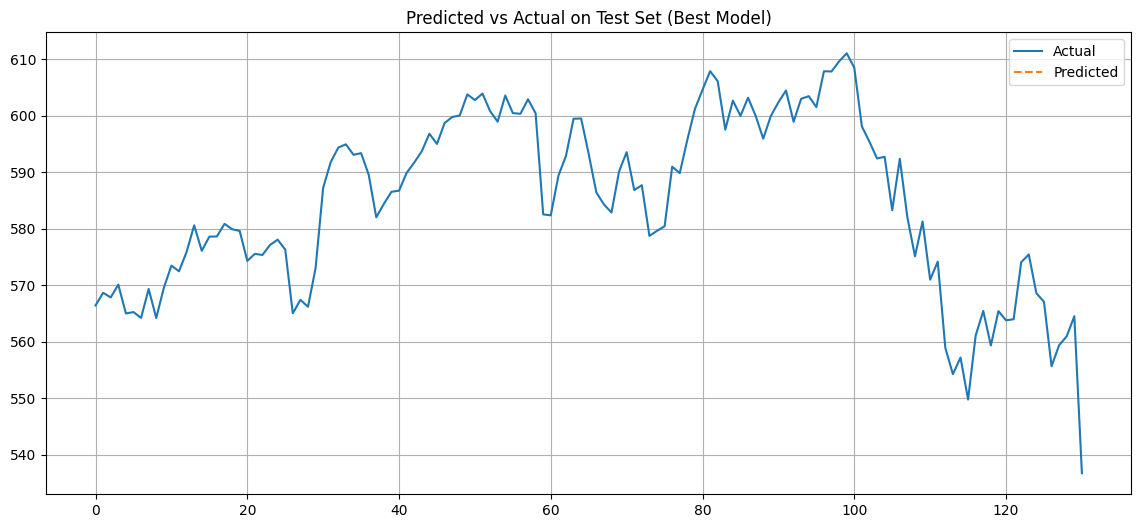

In [163]:
#forecast_df.head()
# Plot predicted vs actual
y_test = y_test.reset_index(drop=True)
forecast_df = forecast_df.reset_index(drop=True)
plt.figure(figsize=(14,6))

plt.plot(y_test, label='Actual')
plt.plot(forecast_df['PREDICTED'], label='Predicted', linestyle='--')


plt.title('Predicted vs Actual on Test Set (Best Model)')
plt.legend()
plt.grid()
plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, 1190 to 1320
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PREDICTED  0 non-null      object
dtypes: object(1)
memory usage: 2.0+ KB
